<a href="https://colab.research.google.com/github/ManuelOtt-code/Project-DC/blob/master/LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin





In [2]:
def drop_non_numeric_columns(df):
    """Drops columns from a DataFrame that do not contain numeric values.

    Args:
        df: The input DataFrame.

    Returns:
        A new DataFrame with non-numeric columns removed.
    """
    numeric_df = df.select_dtypes(include=np.number)
    return numeric_df

In [3]:
# Load data
train_df = pd.read_csv("Landrum_All_training_mordred.csv")
test_df = pd.read_csv("Landrum_All_training_mordred.csv")

train_df=drop_non_numeric_columns(train_df)
test_df=drop_non_numeric_columns(test_df)

# Separate features and labels
X_train = train_df.drop(columns=["active", "Unnamed: 0"], errors="ignore")
y_train = train_df["active"]
X_test = test_df.drop(columns=["active", "Unnamed: 0"], errors="ignore")
y_test = test_df["active"]

# Align and drop missing
shared_cols = X_train.columns.intersection(X_test.columns)
X_train = X_train[shared_cols].dropna(axis=1)
X_test = X_test[X_train.columns].dropna(axis=1)





In [38]:
# Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ("var_thresh", VarianceThreshold(threshold=0.01)),
    ('select', SelectKBest(score_func=f_classif)),
    ('logreg', LogisticRegression(max_iter=1000))
])

param_grid = [
    {
        'logreg__penalty': ['l1'],
        'logreg__C': [0.06, 0.070, 0.075],
        'logreg__solver': ['saga'],
        'select__k': [10, 20, 50]
    },
    {
        'logreg__penalty': ['l2'],
        'logreg__C': [0.06, 0.070, 0.075],
        'logreg__solver': ['saga'],
        'select__k': [10, 20, 50]
    },
    {
        'logreg__penalty': ['elasticnet'],
        'logreg__C': [0.06, 0.070, 0.075],
        'logreg__solver': ['saga'],
        'logreg__l1_ratio': [0.10, 0.20, 0.30],
        'select__k': [10, 20, 50]
    }

]

Best parameters: {'logreg__C': 0.06, 'logreg__penalty': 'l2', 'logreg__solver': 'saga', 'select__k': 20}
Best cross-validation accuracy: 0.6785714285714286


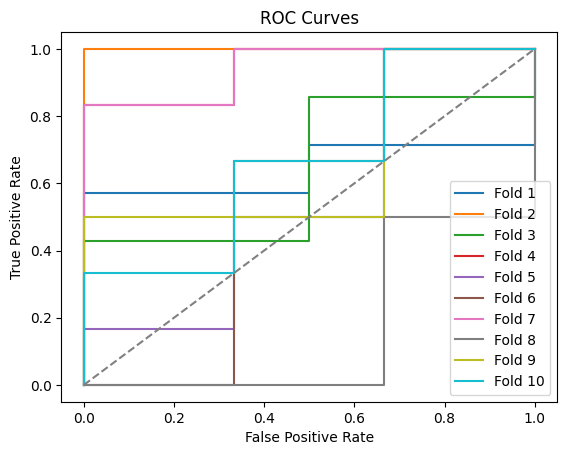

Mean Accuracy: 0.7222222222222222
Mean Precision: 0.7378968253968254
Mean F1 Score: 0.8232509157509156
Mean ROC AUC: 0.6785714285714286


{'accuracies': [0.5555555555555556,
  0.8888888888888888,
  0.7777777777777778,
  0.8888888888888888,
  0.7777777777777778,
  0.7777777777777778,
  0.6666666666666666,
  0.4444444444444444,
  0.6666666666666666,
  0.7777777777777778],
 'precisions': [0.7142857142857143,
  0.875,
  0.7777777777777778,
  0.8571428571428571,
  0.75,
  0.75,
  0.6666666666666666,
  0.5714285714285714,
  0.6666666666666666,
  0.75],
 'f1_scores': [0.7142857142857143,
  0.9333333333333333,
  0.875,
  0.9230769230769231,
  0.8571428571428571,
  0.8571428571428571,
  0.8,
  0.6153846153846154,
  0.8,
  0.8571428571428571],
 'auc_scores': [np.float64(0.6428571428571428),
  np.float64(1.0),
  np.float64(0.6428571428571428),
  np.float64(0.9444444444444445),
  np.float64(0.5555555555555556),
  np.float64(0.5555555555555556),
  np.float64(0.9444444444444445),
  np.float64(0.16666666666666669),
  np.float64(0.6666666666666667),
  np.float64(0.6666666666666667)]}

In [42]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Run grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output best model and parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
evaluate_model_with_cv(best_model, X_train, y_train, random_state=42)




In [41]:
def evaluate_model_with_cv(model, X, y, random_state):
    """
    Evaluate a model using 10-fold cross-validation and return performance metrics.

    Parameters:
        model: The model to evaluate
        X: Feature matrix (DataFrame or array)
        y: Target vector
        random_state: Random seed for reproducibility

    Returns:
        Dictionary with performance metrics and arrays of per-fold metrics
    """
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import (
        accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve
    )
    import matplotlib.pyplot as plt

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    metrics = {
        'accuracies': [],
        'precisions': [],
        'f1_scores': [],
        'auc_scores': []
    }

    plt.figure()

    for k, (train_index, test_index) in enumerate(skf.split(X, y)):
        # Proper slicing for DataFrame or array
        if isinstance(X, pd.DataFrame):
            X_train_fold = X.iloc[train_index]
            X_test_fold = X.iloc[test_index]
        else:
            X_train_fold = X[train_index]
            X_test_fold = X[test_index]

        y_train_fold = y[train_index]
        y_test_fold = y[test_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_test_fold)
        y_proba = model.predict_proba(X_test_fold)[:, 1]

        # Metrics
        metrics['accuracies'].append(accuracy_score(y_test_fold, y_pred))
        metrics['precisions'].append(precision_score(y_test_fold, y_pred))
        metrics['f1_scores'].append(f1_score(y_test_fold, y_pred))
        metrics['auc_scores'].append(roc_auc_score(y_test_fold, y_proba))

        fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
        plt.plot(fpr, tpr, label=f"Fold {k+1}")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

    print("Mean Accuracy:", np.mean(metrics['accuracies']))
    print("Mean Precision:", np.mean(metrics['precisions']))
    print("Mean F1 Score:", np.mean(metrics['f1_scores']))
    print("Mean ROC AUC:", np.mean(metrics['auc_scores']))

    return metrics



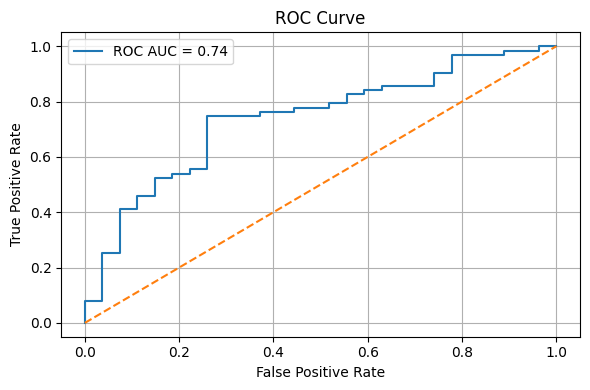

In [33]:
# Evaluate
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

